In [1]:
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label
%matplotlib inline

In [2]:
from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  visualise=True, feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  visualise=False, feature_vector=feature_vec)
        return features

In [3]:
# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
def bin_spatial(img, color_space='YCrCb', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

In [4]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    #return rhist, ghist, bhist, bin_centers, hist_features
    return hist_features

In [5]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # bounding boxes
    bboxes = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            # spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            spatial_features = bin_spatial(subimg)
            #hist_features = []

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((hist_features, hog_features, spatial_features)).reshape(1, -1))      
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return draw_img, bboxes

In [6]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def get_heatmap(img, bbox_list):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat,bbox_list)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    return heatmap

In [7]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [8]:
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

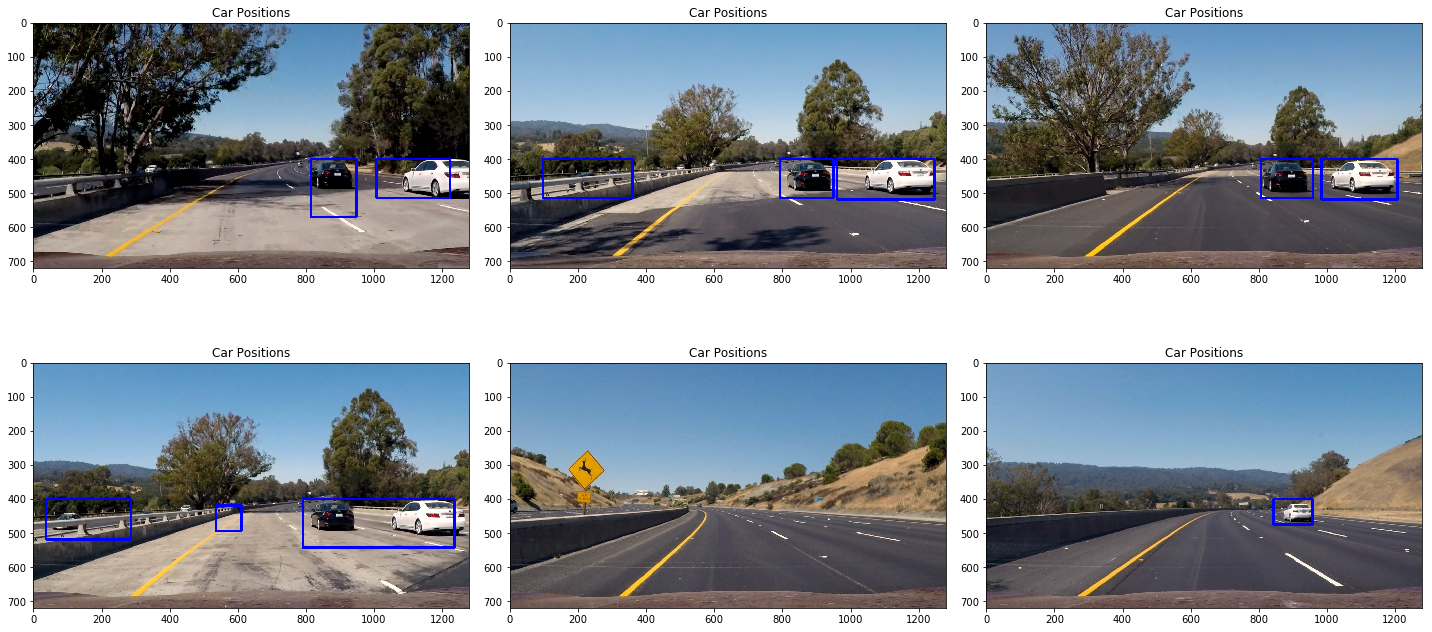

In [18]:
imglist = glob.glob('./test_images/*.jpg')

ystart = 400
ystop = 656
scale = 2.0

fig = plt.figure(figsize=(20, 10))

for i, imgname in enumerate(imglist):
    img = mpimg.imread(imgname)
    
    scale = 1.8
    out_img, bboxes1 = find_cars(img, ystart, ystop, scale, svc, 
                                X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    scale = 1.5
    out_img, bboxes2 = find_cars(img, ystart, ystop, scale, svc, 
                                X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    scale = 1.2
    out_img, bboxes3 = find_cars(img, ystart, ystop, scale, svc, 
                                X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    bboxes = bboxes1 + bboxes2 + bboxes3
    
    heatmap = get_heatmap(out_img, bboxes)
    
    labels = label(heatmap)
    
    out_img = draw_labeled_bboxes(np.copy(img), labels)

    plt.subplot(2,3,i+1)
    plt.imshow(out_img)
    plt.title('Car Positions')
    
fig.tight_layout()
plt.show()
fig.savefig('./examples/sliding_window.png')

/opt/anaconda/3.6/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


2 cars found


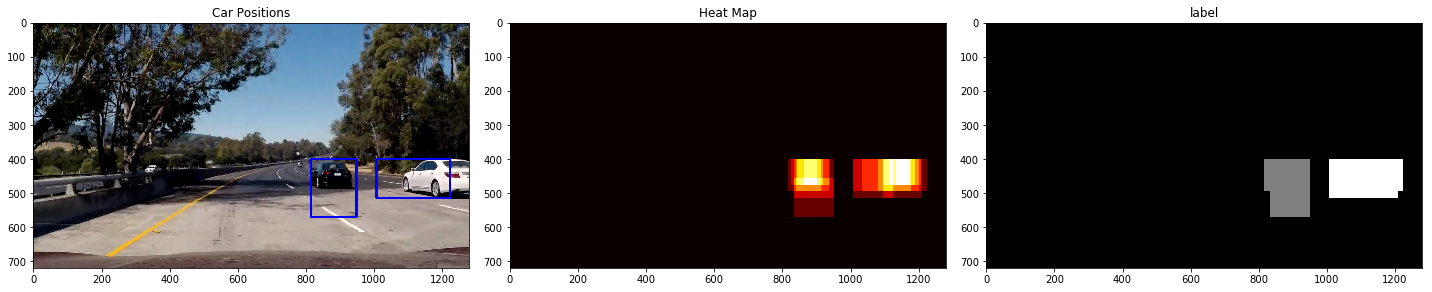

3 cars found


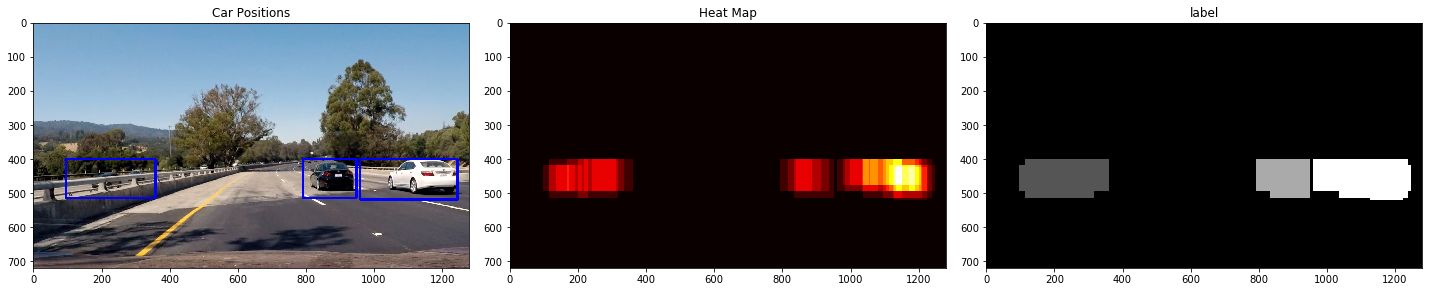

2 cars found


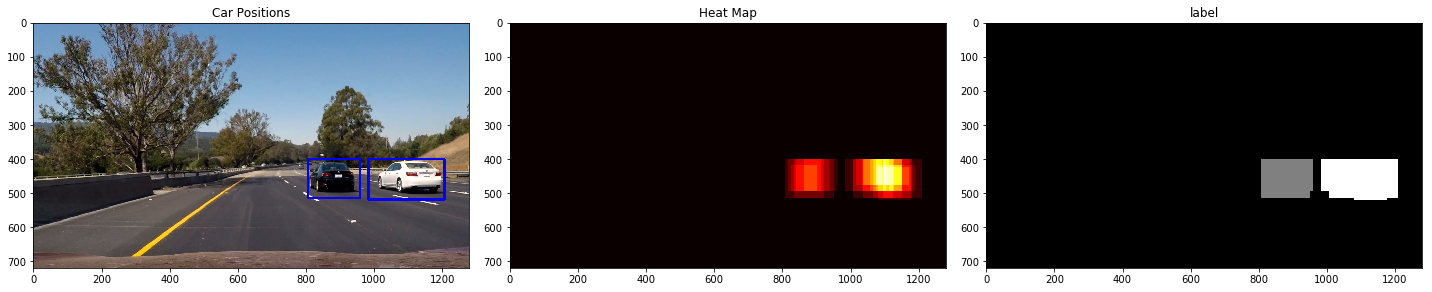

3 cars found


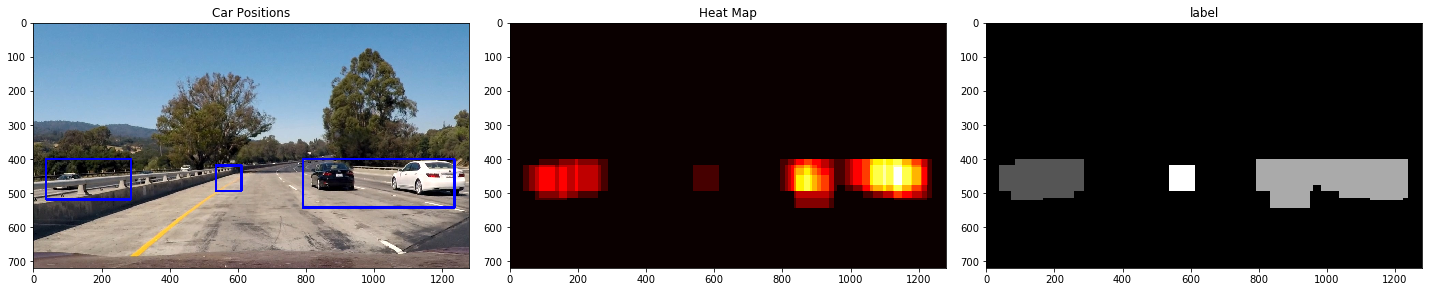

0 cars found


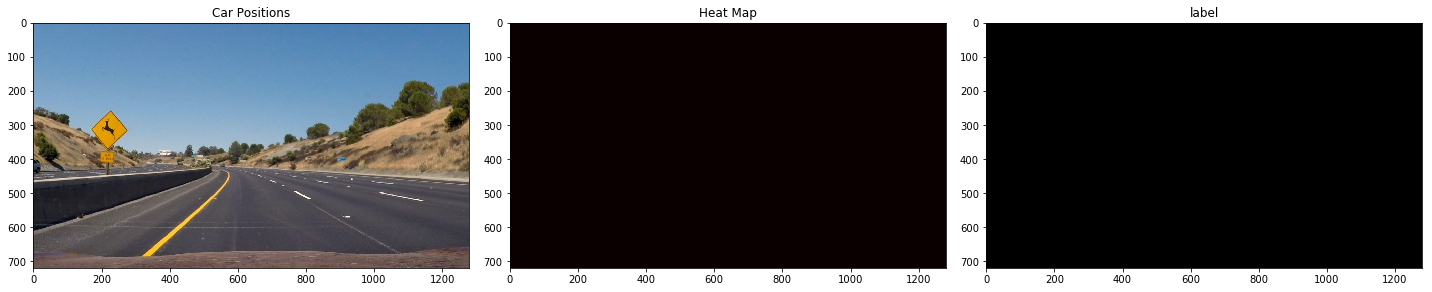

1 cars found


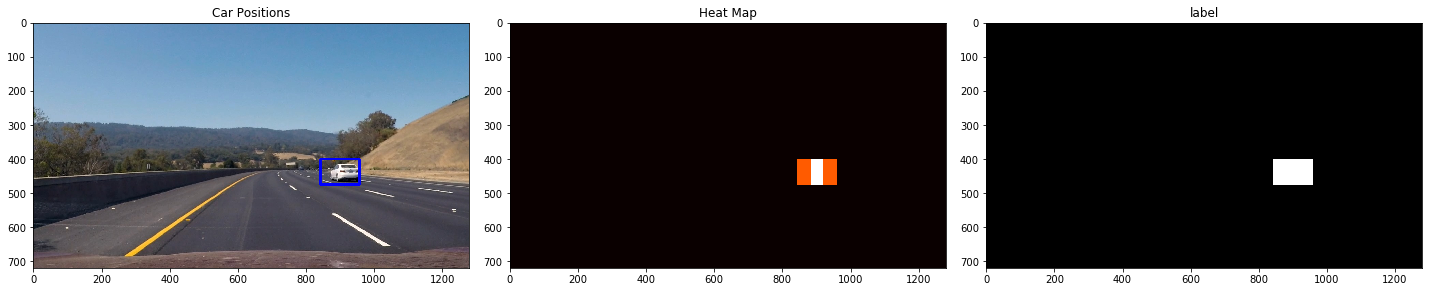

In [9]:
imglist = glob.glob('./test_images/*.jpg')

ystart = 400
ystop = 656
scale = 2.0

for imgname in imglist:
    img = mpimg.imread(imgname)
    
    scale = 1.8
    out_img, bboxes1 = find_cars(img, ystart, ystop, scale, svc, 
                                X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    scale = 1.5
    out_img, bboxes2 = find_cars(img, ystart, ystop, scale, svc, 
                                X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    scale = 1.2
    out_img, bboxes3 = find_cars(img, ystart, ystop, scale, svc, 
                                X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    bboxes = bboxes1 + bboxes2 + bboxes3
    
    heatmap = get_heatmap(out_img, bboxes)
    
    labels = label(heatmap)
    
    out_img = draw_labeled_bboxes(np.copy(img), labels)
    
    fig = plt.figure(figsize=(20, 10))
    
    plt.subplot(131)
    plt.imshow(out_img)
    plt.title('Car Positions')
    
    plt.subplot(132)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    
    plt.subplot(133)
    print(labels[1], 'cars found')
    plt.imshow(labels[0], cmap='gray')
    plt.title('label')
    
    fig.tight_layout()
    plt.show()

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [11]:
global tracks
tracks = []

def check_heatmap(heatmap):
    global tracks
    tracks.append(heatmap)
    newmap = np.zeros_like(heatmap)
    for m in tracks[-3:]:
        newmap += m
        
    # Remove less confident results
    #newmap[newmap <= 2] = 0
    
    return m

In [12]:
def find_cars_mulscale(img):
    scale = 1.8
    out_img, bboxes1 = find_cars(img, ystart, ystop, scale, svc, 
                                X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    scale = 1.2
    out_img, bboxes2 = find_cars(img, ystart, ystop, scale, svc, 
                                X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    scale = 1.5
    out_img, bboxes3 = find_cars(img, ystart, ystop, scale, svc, 
                                X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    bboxes = bboxes1 + bboxes2 + bboxes3
    
    heatmap = get_heatmap(out_img, bboxes)
    
    heatmap = check_heatmap(heatmap)
    
    labels = label(heatmap)
    
    out_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return out_img

In [13]:
video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("./project_video.mp4")

#video_output = 'test_video_output.mp4'
#clip1 = VideoFileClip("./test_video.mp4")

out_clip = clip1.fl_image(find_cars_mulscale) #NOTE: this function expects color images!!
%time out_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output2.mp4
[MoviePy] Writing video project_video_output2.mp4


100%|█████████▉| 1260/1261 [20:43<00:00,  1.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output2.mp4 

CPU times: user 37min 40s, sys: 12.4 s, total: 37min 52s
Wall time: 20min 43s


In [14]:

HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(video_output))